In [1]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        for part_dir in self.root_dir.iterdir():
            if part_dir.is_dir():
                for patient_dir in part_dir.iterdir():
                    if patient_dir.is_dir():
                        for study_dir in patient_dir.iterdir():
                            if study_dir.is_dir():
                                label = 1 if "positive" in study_dir.name else 0
                                for img_path in study_dir.glob("*.png"):
                                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = MURABinaryDataset("/Users/alvarosanchez/Downloads/MURA-v1.1/train", transform=transform_train)
valid_dataset = MURABinaryDataset("/Users/alvarosanchez/Downloads/MURA-v1.1/valid", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [4]:
# Hiperparámetros
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-5
EPOCHS = 25
PATIENCE = 5

In [5]:
from torch.utils.data import DataLoader

# Rutas de entrenamiento y validación
train_dir = "/Users/alvarosanchez/Downloads/MURA-v1.1/train"
valid_dir = "/Users/alvarosanchez/Downloads/MURA-v1.1/valid"

# Creamos los datasets usando nuestra clase personalizada
train_dataset = MURABinaryDataset(train_dir, transform=transform_train)
valid_dataset = MURABinaryDataset(valid_dir, transform=transform_val)

# DataLoaders con shuffle para train
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
import torch
import torch.nn as nn
from torchvision import models

# Detectar si hay GPU o MPS (Apple Silicon) disponible
DEVICE = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Cargar modelo ResNet18 preentrenado en ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Congelar todas las capas convolucionales
for param in resnet18.parameters():
    param.requires_grad = False

# Reemplazar la capa final (fc) para clasificación binaria
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)  # 2 clases: 0 (negative), 1 (positive)

# Enviar el modelo al dispositivo
resnet18 = resnet18.to(DEVICE)

# Ver estructura del modelo (útil para tu exposición)
print(resnet18)

Usando dispositivo: mps
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

In [7]:
import torch.optim as optim

# Función de pérdida para clasificación binaria
criterion = nn.CrossEntropyLoss()

# Optimizador: solo entrenamos los parámetros de la capa final
optimizer = optim.Adam(resnet18.fc.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler que reduce el LR si el val_loss no mejora
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

for epoch in range(EPOCHS):
    resnet18.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #Evaluación en validación
    resnet18.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    #Métricas
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="binary")

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    #Guardar el mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(resnet18.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV5.pt")
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping activado.")
            break

Epoch 1 | Train Loss: 0.6658 | Val Loss: 0.6686 | Acc: 0.5990 | F1: 0.4737
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.6357 | Val Loss: 0.6865 | Acc: 0.5874 | F1: 0.3294
Epoch 3 | Train Loss: 0.6220 | Val Loss: 0.6764 | Acc: 0.6037 | F1: 0.3816
Epoch 4 | Train Loss: 0.6172 | Val Loss: 0.6665 | Acc: 0.6193 | F1: 0.4278
Mejor modelo guardado.
Epoch 5 | Train Loss: 0.6102 | Val Loss: 0.6548 | Acc: 0.6322 | F1: 0.4712
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.6065 | Val Loss: 0.6502 | Acc: 0.6406 | F1: 0.4887
Mejor modelo guardado.
Epoch 7 | Train Loss: 0.6049 | Val Loss: 0.6599 | Acc: 0.6290 | F1: 0.4514
Epoch 8 | Train Loss: 0.6014 | Val Loss: 0.6660 | Acc: 0.6250 | F1: 0.4304
Epoch 9 | Train Loss: 0.6024 | Val Loss: 0.6409 | Acc: 0.6456 | F1: 0.5076
Mejor modelo guardado.
Epoch 10 | Train Loss: 0.6000 | Val Loss: 0.6429 | Acc: 0.6431 | F1: 0.4949
Epoch 11 | Train Loss: 0.5987 | Val Loss: 0.6414 | Acc: 0.6428 | F1: 0.4960
Epoch 12 | Train Loss: 0.5987 | Val Loss: 0.6470 | Acc: 0.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

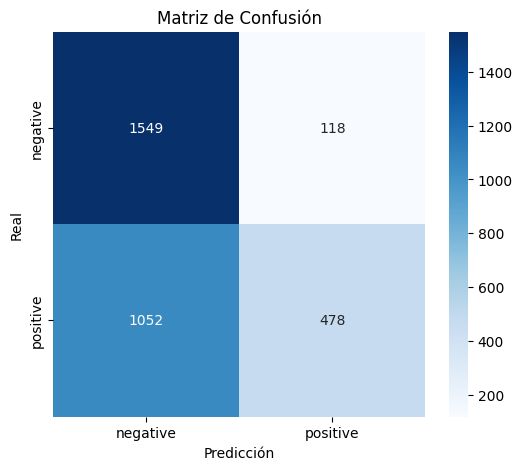


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.93      0.73      1667
    positive       0.80      0.31      0.45      1530

    accuracy                           0.63      3197
   macro avg       0.70      0.62      0.59      3197
weighted avg       0.69      0.63      0.59      3197



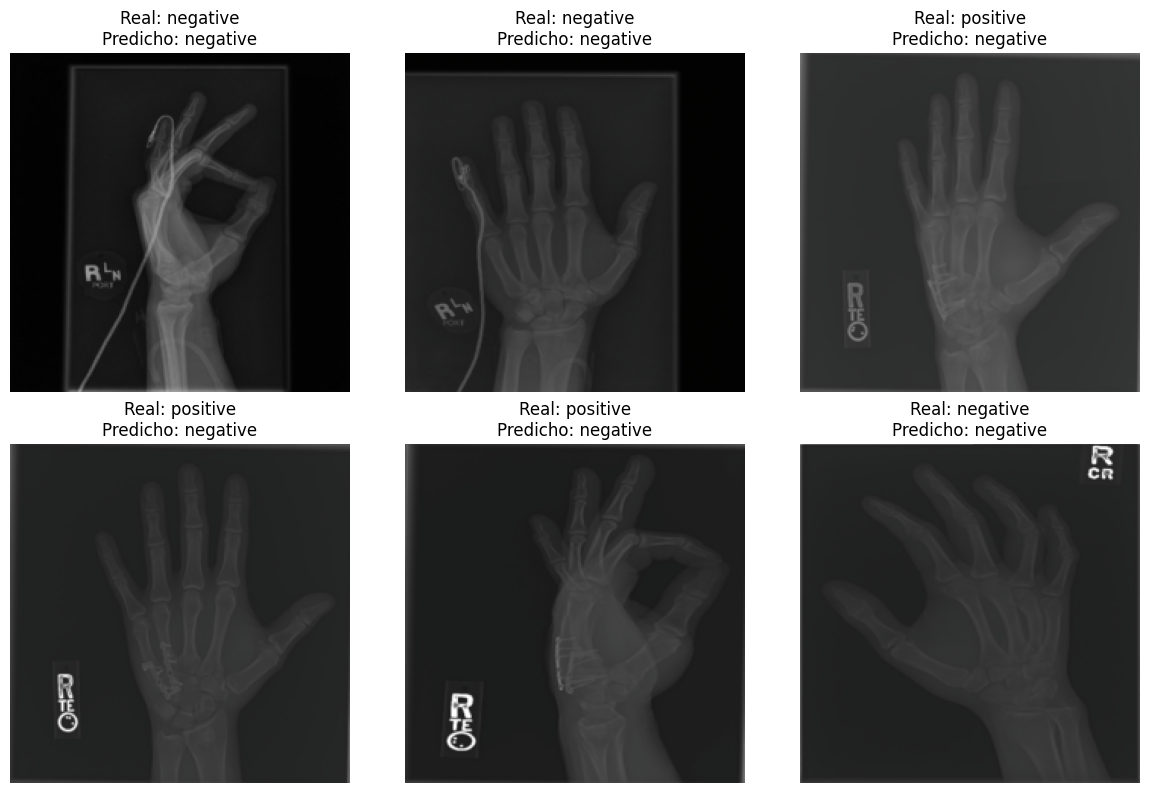

In [12]:
from torchvision.utils import make_grid

# Asegúrate de que el modelo está en modo evaluación
resnet18.eval()

# Listas para guardar resultados
y_true = []
y_pred = []
images_list = []

# Sin gradiente
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        images_list.extend(inputs.cpu())  # guardar imágenes originales

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
class_names = ["negative", "positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Clasification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Visualización de predicciones
def imshow(inp, title=None):
    """Visualiza una imagen normalizada"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean  # desnormalizar
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Mostrar 6 ejemplos de predicciones
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    title = f"Real: {true_label}\nPredicho: {pred_label}"
    imshow(images_list[i], title=title)

plt.tight_layout()
plt.show()